In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('ggplot')
%matplotlib inline

from sklearn import cluster, feature_extraction, decomposition, manifold, metrics, datasets
from scipy.spatial import distance

## Data loading

In [3]:
dataset = datasets.load_iris()
X = dataset.data
y = dataset.target
n_topics = len(set(y))
n_topics

3

In [4]:
X.shape

(150, 4)

## Distance Matrix
**Cosine metric** is a popular choice for computing the similarity of documents represented as tf-idf vectors.

In [5]:
# condensed(triangular) distance matrix
cos = distance.pdist(X, metric='cosine') 
# converts from condensed distance matrix to square distance matrices
cos = distance.squareform(cos)

## Clusters number defining

In [6]:
np.random.seed(234)
n = X.shape[0] # sample size
K = range(5, 21)

silhouette_avg = []
inertia = []

for k in K:
    kmeans = cluster.MiniBatchKMeans(n_clusters=k).fit(X)
    silhouette_avg.append(metrics.silhouette_score(cos, kmeans.labels_, metric="precomputed"))
    inertia.append(kmeans.inertia_)

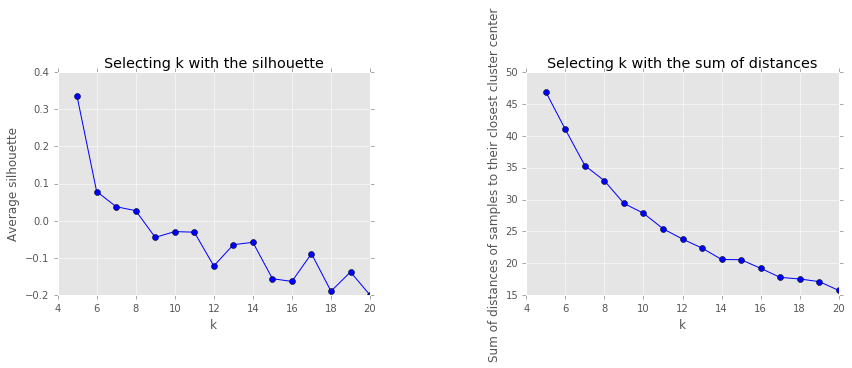

In [7]:
plt.figure(figsize=(14,4))
plt.subplots_adjust(hspace=0.2, wspace=0.5)

plt.subplot(121)
plt.plot(K, silhouette_avg, 'bo-')
plt.xlabel('k')
plt.ylabel('Average silhouette')
plt.title('Selecting k with the silhouette')
plt.grid(True)

plt.subplot(122)
plt.plot(K, inertia, 'bo-')
plt.xlabel('k')
plt.ylabel('Sum of distances of samples to their closest cluster center')
plt.title('Selecting k with the sum of distances')
plt.grid(True)

plt.show()

In [8]:
n = X.shape[0] # sample size
K = range(5, 21)

silhouette_avg = []

for k in K:
    kmeans = cluster.hierarchical.AgglomerativeClustering(n_clusters=k,affinity='precomputed', linkage='complete').fit(cos)
    silhouette_avg.append(metrics.silhouette_score(cos, kmeans.labels_, metric="precomputed"))


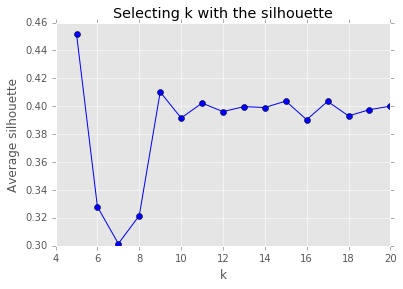

In [9]:
plt.subplot(111)
plt.plot(K, silhouette_avg, 'bo-')
plt.xlabel('k')
plt.ylabel('Average silhouette')
plt.title('Selecting k with the silhouette')
plt.grid(True)

В случае кластеризации текста (тематическое моделирование), или поиска сообществ в социальном графе, выборка имеет ряд отличительных причин:
- высокоразмерное признаковое пространство
- разреженные данные
- данные распределены по степенному закону

В таком случае методы определения числа кластеров (silhouette measure, Elbow method) не работают.

## Feature space decomposition and visualization
To define clustering structure it is useful to visualize it into 2D or 3D space

### linear method

#### PCA

In [10]:
# TruncatedSVD is very similar to PCA, but differs in that it works on sample matrices X 
# directly instead of their covariance matrices.

svd2d = decomposition.TruncatedSVD(n_components=2, algorithm='randomized', n_iter=5, random_state=0)
data_svd2d = svd2d.fit_transform(X)

In [11]:
svd3d = decomposition.TruncatedSVD(n_components=3, algorithm='randomized', n_iter=5, random_state=0)
data_svd3d = svd3d.fit_transform(X)

In [12]:
def renderClusters(data2d, data3d):
    fig = plt.figure(figsize=(14,6))

    ax1 = fig.add_subplot(121)
    ax1.scatter(data2d[:, 0], data2d[:, 1], c = y)

    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(data3d[:, 0], data3d[:, 1], data3d[:, 2],c = y, zdir='z')

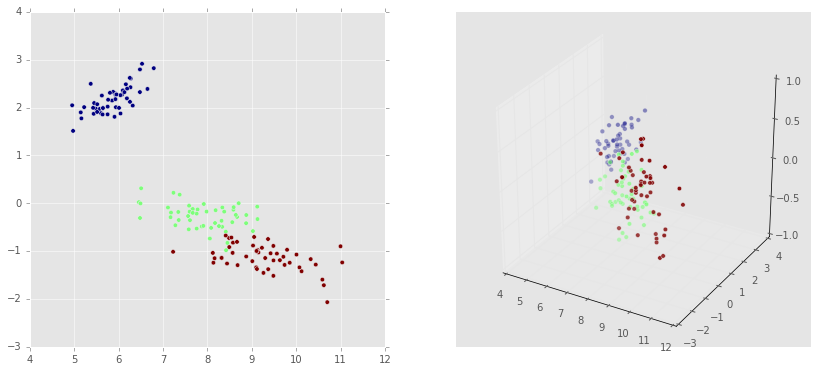

In [13]:
renderClusters(data_svd2d, data_svd3d)

### Non-linear methods

#### Isomap

In [14]:
isomap2d = manifold.Isomap(n_neighbors=15, n_components=2)
data_isomap2d = isomap2d.fit_transform(X)

In [15]:
isomap3d = manifold.Isomap(n_neighbors=15, n_components=3)
data_isomap3d = isomap3d.fit_transform(X)

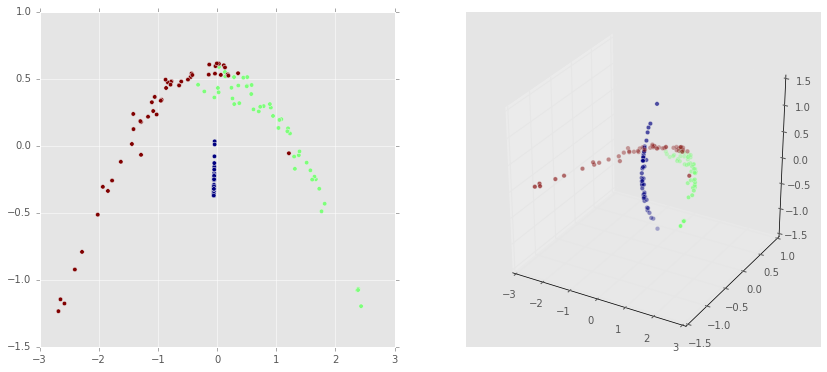

In [16]:
renderClusters(data_isomap2d, data_isomap3d)

#### MDS

In [17]:
mds2d = manifold.MDS(n_components=2, metric=True, n_init=4, max_iter=300, dissimilarity='precomputed')
data_mds2d = mds2d.fit_transform(cos)

In [18]:
mds3d = manifold.MDS(n_components=3, metric=True, n_init=4, max_iter=300, dissimilarity='precomputed')
data_mds3d = mds3d.fit_transform(cos)

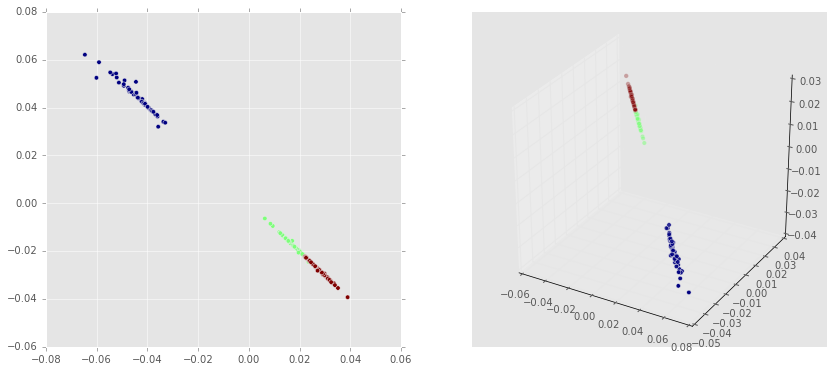

In [19]:
renderClusters(data_mds2d, data_mds3d)

#### t-SNE

In [20]:
tsne2d = manifold.TSNE(n_components=2, metric='precomputed', init='random', random_state=0)
data_tsne2d = tsne2d.fit_transform(cos)

In [21]:
tsne3d = manifold.TSNE(n_components=3, metric='precomputed', init='random', random_state=0)
data_tsne3d = tsne3d.fit_transform(cos)

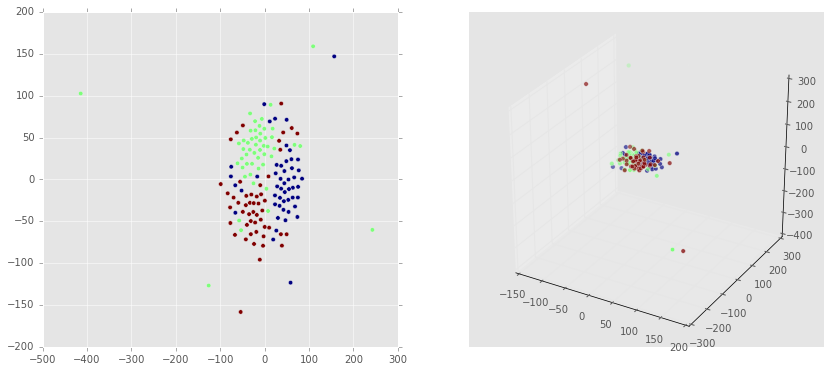

In [22]:
renderClusters(data_tsne2d, data_tsne3d)

## Clustering

### kmeans

In [23]:
np.random.seed(234)
kmeans = cluster.MiniBatchKMeans(n_clusters=n_topics).fit(X)
preds = kmeans.predict(X)

In [24]:
import itertools
def getMappedPreds(preds, target):
    # target labels
    labels = range(len(set(target)))
    
    # all possible permutations of lzbels
    permutations = itertools.permutations(labels)
    
    error_percent = []
    for i in permutations:
        mapping = dict(zip([j for j in i], labels))
        
        mapped_preds = [mapping[pred] for pred in preds]
        
        # tuple (error_percent, mapping)
        error_percent.append((float(sum(mapped_preds != target)) / len(target), mapping))
        
    mapping = error_percent[np.argmin([i[0] for i in error_percent])][1]
    
    return [mapping[pred] for pred in preds]

In [25]:
def drawLabelDistribution(preds, target):    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,4))
    f.subplots_adjust(hspace=0.2, wspace=0.5)
    f.suptitle('Distribution by classes', fontsize=16, y=1.05)

    ax1.set_title('Predictions')
    ax1.set_xlabel('predicted classes')
    ax1.set_ylabel('Count')
    ax1.hist(preds)


    ax2.set_title('True labels')
    ax2.set_xlabel('predicted classes')
    ax2.hist(target)

    plt.show()

In [26]:
mapped_preds = getMappedPreds(preds, y)
err_kmeans = float(sum(mapped_preds != y)) / len(y)
print 'Error fraction:', err_kmeans

Error fraction: 0.106666666667


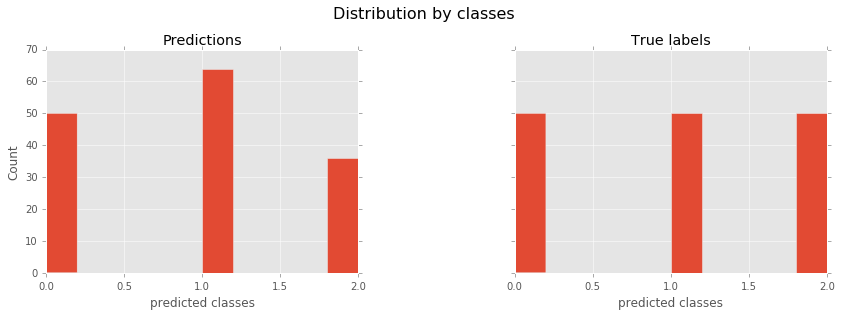

In [27]:
drawLabelDistribution(mapped_preds, y)

In [28]:
print (metrics.classification_report(y, mapped_preds))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       0.77      0.98      0.86        50
          2       0.97      0.70      0.81        50

avg / total       0.91      0.89      0.89       150



In [29]:
print (metrics.confusion_matrix(y, mapped_preds))

[[50  0  0]
 [ 0 49  1]
 [ 0 15 35]]


### agglomerative clustering

In [30]:
hier = cluster.hierarchical.AgglomerativeClustering(n_clusters=n_topics, affinity='precomputed', linkage='complete')

In [31]:
preds = hier.fit_predict(cos)

In [32]:
mapped_preds = getMappedPreds(preds, y)
err_aggl = float(sum(mapped_preds != y)) / len(y)
print 'Error fraction:', err_aggl 

Error fraction: 0.16


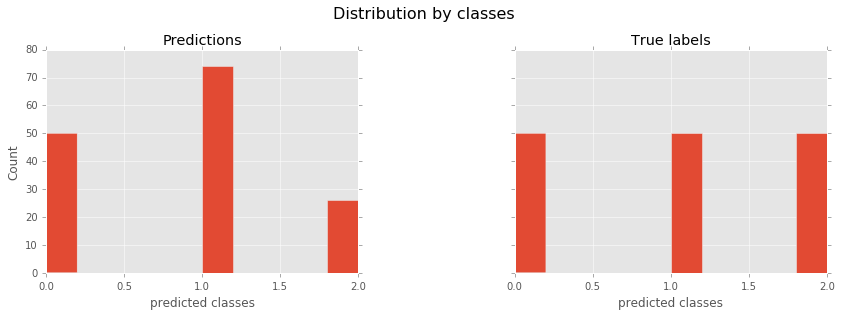

In [33]:
drawLabelDistribution(mapped_preds, y)

In [34]:
print (metrics.classification_report(y, mapped_preds))
print (metrics.confusion_matrix(y, mapped_preds))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       0.68      1.00      0.81        50
          2       1.00      0.52      0.68        50

avg / total       0.89      0.84      0.83       150

[[50  0  0]
 [ 0 50  0]
 [ 0 24 26]]


### clustering with decomposition

#### SVD + kmeans

In [36]:
np.random.seed(234)
svd = decomposition.TruncatedSVD(n_components=X.shape[1]/3)
features = svd.fit_transform(X)

In [37]:
np.random.seed(234)
kmeans = cluster.MiniBatchKMeans(n_clusters=n_topics)
preds = kmeans.fit_predict(features)

mapped_preds = getMappedPreds(preds, y)
err_svdkmeans = float(sum(mapped_preds != y)) / len(y)
print 'Error fraction:', err_svdkmeans

Error fraction: 0.153333333333


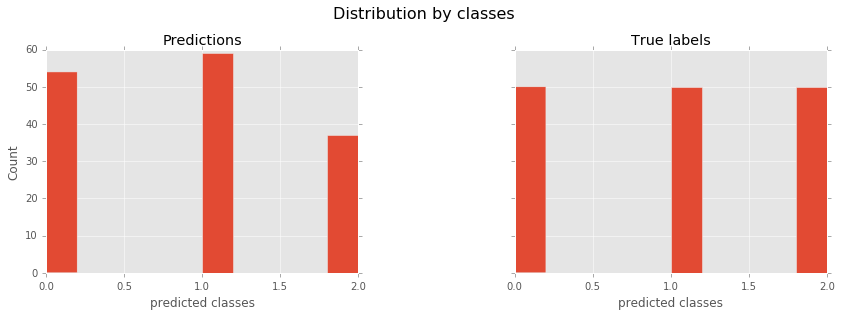

In [38]:
drawLabelDistribution(mapped_preds, y)

In [39]:
print (metrics.classification_report(y, mapped_preds))
print (metrics.confusion_matrix(y, mapped_preds))

             precision    recall  f1-score   support

          0       0.93      1.00      0.96        50
          1       0.73      0.86      0.79        50
          2       0.92      0.68      0.78        50

avg / total       0.86      0.85      0.84       150

[[50  0  0]
 [ 4 43  3]
 [ 0 16 34]]


#### SVD + Agglomerative

In [40]:
hier = cluster.hierarchical.AgglomerativeClustering(n_clusters=n_topics, affinity='cosine', linkage='complete')
preds = hier.fit_predict(features)

mapped_preds = getMappedPreds(preds, y)
err_svdaggl = float(sum(mapped_preds != y)) / len(y)
print 'Error fraction:', err_svdaggl

Error fraction: 0.66


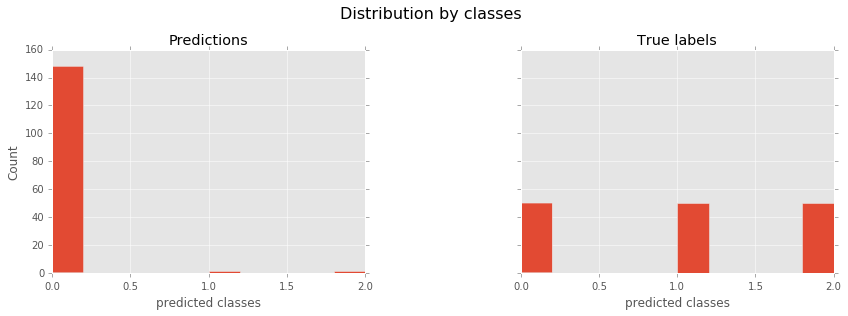

In [41]:
drawLabelDistribution(mapped_preds, y)

In [42]:
print (metrics.classification_report(y, mapped_preds))
print (metrics.confusion_matrix(y, mapped_preds))

             precision    recall  f1-score   support

          0       0.34      1.00      0.51        50
          1       0.00      0.00      0.00        50
          2       1.00      0.02      0.04        50

avg / total       0.45      0.34      0.18       150

[[50  0  0]
 [50  0  0]
 [48  1  1]]


## Comparising clustering methods performance

<Container object of 4 artists>

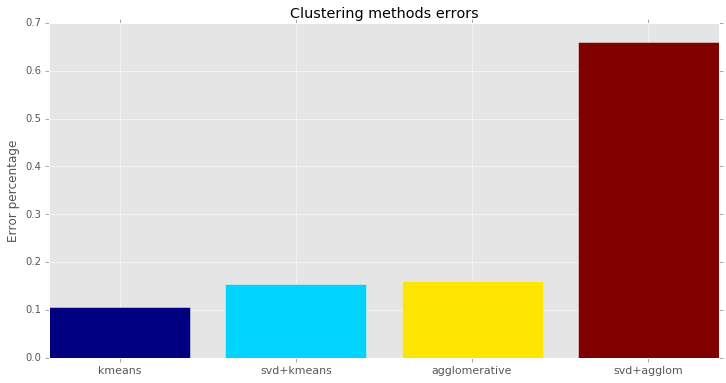

In [47]:
# sorting errorrs percentage by value 
d = sorted(zip([err_kmeans, err_aggl, err_svdkmeans, err_svdaggl], 
               ['kmeans', 'agglomerative', 'svd+kmeans', 'svd+agglom']))

errors = [i[0] for i in d]
xlabels = [i[1] for i in d]

ticks = range(len(errors))

colors = plt.cm.jet(np.linspace(0,1, len(errors)))

plt.figure(figsize=(12,6))
plt.xticks(ticks, xlabels, size=11)
plt.title('Clustering methods errors')
plt.ylabel('Error percentage')
plt.bar(ticks, errors, align='center',color=colors)